# PyTorch 常用代码片段

笔记出处位于知乎文档: [PyTorch常用代码段](https://zhuanlan.zhihu.com/p/104019160)

## 基本配置

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# 如果引用torchvision失败，可能是pillow的组件版本过高
# 可以先卸载本地的pillow，然后pip install pillow==6.2.2
import torchvision
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))

1.10.1+cu113
11.3
8200
NVIDIA T1200 Laptop GPU


### 可复现性

在硬件设备（CPU、GPU）不同时，完全的可复现性无法保证，即使随机种子相同。但是，在同一个设备上，应该保证可复现性。具体做法是，在程序开始的时候固定torch的随机种子，同时也把numpy的随机种子固定。

In [3]:
import numpy as np
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### 显卡设置

如果只需要一张显卡

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

如果需要指定多张显卡，比如0，1号显卡。

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

也可以在命令行运行代码时设置显卡：

In [ ]:
# CUDA_VISIBLE_DEVICES=0,1 python train.py

清除显存

In [6]:
torch.cuda.empty_cache()

也可以使用在命令行重置GPU的指令

In [7]:
# nvidia-smi --gpu-reset -i 0

## 张量处理

### 张量的数据类型

PyTorch有9种CPU张量类型和9种GPU张量类型。

<img src="./image/torch_tensor.jpg"  alt="Tensor types" />

### 张量基本信息

In [8]:
tensor = torch.randn(3,4,5)
print(tensor.type())  # 数据类型
print(tensor.size())  # 张量的shape，是个元组
print(tensor.dim())   # 维度的数量

torch.FloatTensor
torch.Size([3, 4, 5])
3


### 命名张量

张量命名是一个非常有用的方法，这样可以方便地使用维度的名字来做索引或其他操作，大大提高了可读性与易用性，防止出错

In [9]:
# 在PyTorch 1.3之前，需要使用注释
# Tensor[N, C, H, W]
images = torch.randn(32, 3, 56, 56)
print(images.size())
images.sum(dim = 1)
images.select(dim = 1, index = 0)

torch.Size([32, 3, 56, 56])


tensor([[[-1.1256e+00, -3.1700e-01, -1.0925e+00,  ..., -4.1891e-01,
          -8.0483e-01,  5.6561e-01],
         [ 1.8037e-01,  1.0833e-01, -7.5482e-01,  ..., -7.2091e-01,
           1.4708e+00,  2.7564e-01],
         [ 1.1025e-01, -8.1881e-01,  6.3277e-01,  ..., -1.7557e+00,
           7.6166e-02, -1.0786e+00],
         ...,
         [ 6.3545e-01,  3.0746e-01, -1.2414e+00,  ..., -1.8328e+00,
           8.8194e-01, -1.3492e+00],
         [-2.0224e-01,  4.5614e-01,  3.7426e-01,  ..., -2.2916e-01,
          -2.3076e-01, -4.9349e-01],
         [-2.3604e-01, -1.6773e-01,  4.4987e-01,  ..., -8.7382e-01,
          -4.8728e-01, -1.6210e-01]],

        [[-5.8514e-01,  3.1384e-02, -2.4608e-02,  ...,  5.7994e-01,
          -3.6082e-01,  3.1634e-01],
         [ 4.7955e-01,  8.3371e-01,  8.7849e-01,  ..., -5.5736e-01,
           1.4210e+00,  1.4998e-01],
         [-3.0390e-01, -8.2490e-01, -1.6068e+00,  ...,  3.1689e-02,
           2.3211e+00,  1.1986e-01],
         ...,
         [ 8.3218e-01, -4

In [10]:
# 只有1.3之后才支持张量命名
NCHW = ['N', 'C', 'H', 'W']
images = torch.randn(32, 3, 56, 56, names=NCHW)
images.sum('C')
images.select('C', index=0)
# 也可以这么设置
tensor = torch.rand(3,4,1,2,names=('C', 'N', 'H', 'W'))
# 使用align_to可以对维度方便地排序
tensor = tensor.align_to('N', 'C', 'H', 'W')

C:\Users\bhe\AppData\Local\Temp\ipykernel_3296\2298788864.py:3: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1408.)
  images = torch.randn(32, 3, 56, 56, names=NCHW)


获得索引为2的图片的，三通道各个通道的H x W各个像素的值

In [25]:
images.select('N', index=2)

tensor([[[ 0.7138, -0.6633,  1.0524,  ...,  2.0533, -0.7963, -0.9969],
         [ 0.2753, -1.4219, -0.6286,  ..., -1.3472,  0.0827,  0.5386],
         [-0.3576, -0.2102, -2.0285,  ...,  0.3431,  0.7002,  1.6138],
         ...,
         [ 0.2510, -1.4003,  0.6538,  ...,  0.4497,  0.3211,  0.4260],
         [-0.8903,  1.0223, -1.8973,  ..., -1.1942, -1.3702, -1.1444],
         [ 0.4237,  0.6935,  0.0447,  ..., -1.2818,  0.2841,  1.2318]],

        [[-0.2140,  0.5972,  0.7531,  ...,  0.2852, -0.4311, -0.2015],
         [-0.4507, -0.4394,  0.7155,  ..., -0.4807, -0.0332, -0.1083],
         [ 0.9769,  0.2909,  0.3756,  ...,  1.2771, -0.1840, -2.0315],
         ...,
         [-0.6552,  0.4039,  0.3572,  ...,  2.4456, -1.2825, -0.3519],
         [-0.9825, -1.8513,  0.6079,  ...,  0.9773, -0.0078,  0.4368],
         [ 1.1155,  1.5020, -1.0494,  ..., -0.4839,  0.5528, -0.8510]],

        [[-0.6672, -0.9940,  2.0881,  ...,  0.3485,  0.9988,  0.1034],
         [ 0.4622,  0.8260, -1.6992,  ...,  0

### 数据类型转换

In [26]:
# 设置默认类型，pytorch中的Float Tensor远远快于DoubleTensor
torch.set_default_tensor_type(torch.FloatTensor)

# 类型转换
tensor = tensor.cuda()
tensor = tensor.cpu()
tensor = tensor.float()
tensor = tensor.long()

### torch.Tensor与np.ndarray转换

除了CharTensor，其他所有CPU上的张量都支持转换为numpy格式，然后再转换回来

In [31]:
ndarray = tensor.cpu().numpy()
print(ndarray.size)
tensor = torch.from_numpy(ndarray).float()
tensor = torch.from_numpy(ndarray.copy()).float()
print(type(tensor))

24
<class 'torch.Tensor'>


In [32]:
tensor

tensor([[[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]]])

### Torch.tensor与PIL.Image转换

In [33]:
import PIL

In [34]:
data = torch.clamp(tensor * 255, min = 0, max = 255)
type(data.numpy())

numpy.ndarray

In [36]:
data.numpy()

array([[[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]],


       [[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]],


       [[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]],


       [[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]]], dtype=float32)

torch.Size([32, 3, 56, 56])


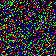

In [94]:
# 不清楚为什么，总是报错
# pytorch中的张量默认采用[N, C, H, W]的顺序，并且数据范围在[0,1]，需要进行转置和规范化
# torch.Tensor -> PIL.Image
print(images.size())
image = PIL.Image.fromarray(images.select('N', index=2).numpy().transpose(1, 2, 0).astype(np.uint8))
image

In [99]:
image = torchvision.transforms.functional.to_pil_image(images.select('N', index=2))

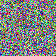

In [100]:
image

In [101]:
import numpy as np

In [102]:
path = r'./image/lstm_3.png'
img_tensor = torch.from_numpy(np.asarray(PIL.Image.open(path))).permute(2,0,1).float() / 255

C:\Users\bhe\AppData\Local\Temp\ipykernel_3296\1014360279.py:2: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:189.)
  img_tensor = torch.from_numpy(np.asarray(PIL.Image.open(path))).permute(2,0,1).float() / 255


In [103]:
img_tensor.size()

torch.Size([4, 398, 645])

In [104]:
# 等同torch直接转换
img_tensor = torchvision.transforms.functional.to_tensor(PIL.Image.open(path)) 

In [105]:
img_tensor.size()

torch.Size([4, 398, 645])

In [106]:
new_image = torchvision.transforms.functional.to_pil_image(img_tensor)

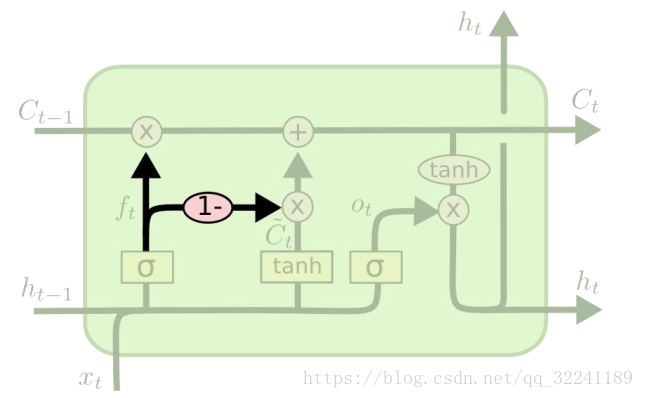

In [107]:
new_image

整合为读取图片并显示的方法

In [108]:
# torchvision的to_tensor与to_pil_image与PIL实现方式等价，但代码更简洁
def load_image(img_path: str):
#     img_tensor = torch.from_numpy(np.asarray(PIL.Image.open(img_path))).permute(2,0,1).float() / 255
    img_tensor = torchvision.transforms.functional.to_tensor(PIL.Image.open(path)) 
    new_image = torchvision.transforms.functional.to_pil_image(img_tensor)
    return img_tensor, new_image

In [109]:
img_tensor, new_image = load_image(r'./image/lstm_3.png')

In [110]:
type(new_image)

PIL.Image.Image

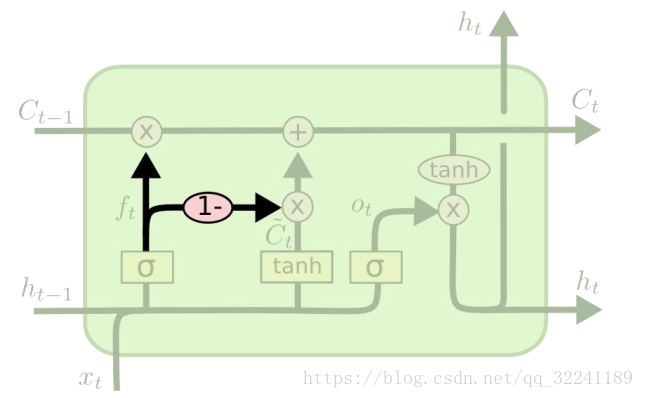

In [111]:
new_image

In [114]:
tensor

tensor([[[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]]])

In [115]:
ndarray = tensor.cpu().numpy()

In [116]:
ndarray

array([[[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]],


       [[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]],


       [[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]],


       [[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]]], dtype=float32)

In [117]:
tensor.size()

torch.Size([4, 3, 1, 2])

In [119]:
small_img = torchvision.transforms.functional.to_pil_image(tensor.select(0, index=2))

In [120]:
small_img

In [121]:
to_ndarray = np.asarray(small_img)

In [122]:
to_ndarray.shape

(1, 2, 3)

In [124]:
to_ndarray.reshape(3, 2, 1)

array([[[0],
        [0]],

       [[0],
        [0]],

       [[0],
        [0]]], dtype=uint8)

### 从只包含一个元素的张量中取值

In [125]:
value = torch.rand(1).item()

In [126]:
value

0.2226872444152832

### 张量形变

In [127]:
# 在将卷积层输入全连接层的情况下通常需要对张量做形变处理，
# 相比torch.view，torch.reshape可以自动处理输入张量不连续的情况。
tensor = torch.rand(2,3,4)
print(tensor)
shape = (6, 4)
tensor = torch.reshape(tensor, shape)

tensor([[[0.1158, 0.3477, 0.6113, 0.9434],
         [0.0318, 0.7620, 0.4296, 0.1309],
         [0.8651, 0.9419, 0.5918, 0.3231]],

        [[0.6129, 0.0975, 0.4773, 0.0304],
         [0.3715, 0.6442, 0.4109, 0.9118],
         [0.8379, 0.1717, 0.6635, 0.0472]]])


In [128]:
tensor

tensor([[0.1158, 0.3477, 0.6113, 0.9434],
        [0.0318, 0.7620, 0.4296, 0.1309],
        [0.8651, 0.9419, 0.5918, 0.3231],
        [0.6129, 0.0975, 0.4773, 0.0304],
        [0.3715, 0.6442, 0.4109, 0.9118],
        [0.8379, 0.1717, 0.6635, 0.0472]])

### 打乱顺序

In [129]:
tensor = torch.rand(3,3,4)
tensor

tensor([[[0.5576, 0.6424, 0.7417, 0.2296],
         [0.7833, 0.3558, 0.9430, 0.0627],
         [0.2629, 0.3156, 0.4051, 0.4154]],

        [[0.2085, 0.3284, 0.1136, 0.8393],
         [0.2228, 0.3848, 0.6307, 0.2803],
         [0.7800, 0.0734, 0.4545, 0.2060]],

        [[0.7897, 0.9334, 0.9775, 0.0305],
         [0.5866, 0.0285, 0.7665, 0.0353],
         [0.0144, 0.4041, 0.8637, 0.6763]]])

In [130]:
# 打乱第一个维度
tensor = tensor[torch.randperm(tensor.size(0))]
tensor

tensor([[[0.2085, 0.3284, 0.1136, 0.8393],
         [0.2228, 0.3848, 0.6307, 0.2803],
         [0.7800, 0.0734, 0.4545, 0.2060]],

        [[0.5576, 0.6424, 0.7417, 0.2296],
         [0.7833, 0.3558, 0.9430, 0.0627],
         [0.2629, 0.3156, 0.4051, 0.4154]],

        [[0.7897, 0.9334, 0.9775, 0.0305],
         [0.5866, 0.0285, 0.7665, 0.0353],
         [0.0144, 0.4041, 0.8637, 0.6763]]])

### 水平翻转

In [132]:
# pytorch不支持tensor[::-1]这样的负步长操作，水平翻转可以通过张量索引实现
# 假设张量的维度为[N, D, H, W].
tensor = torch.rand(2, 3, 3, 4)
tensor

tensor([[[[0.4005, 0.3825, 0.6485, 0.6313],
          [0.8387, 0.0806, 0.0942, 0.0920],
          [0.3634, 0.5975, 0.4373, 0.8862]],

         [[0.9996, 0.6303, 0.0413, 0.6126],
          [0.5909, 0.0300, 0.4062, 0.5194],
          [0.8591, 0.5685, 0.9102, 0.3388]],

         [[0.0443, 0.0662, 0.7568, 0.5242],
          [0.4950, 0.0123, 0.4894, 0.4646],
          [0.2161, 0.8486, 0.4152, 0.3489]]],


        [[[0.1906, 0.3061, 0.8671, 0.6222],
          [0.2920, 0.4149, 0.7301, 0.6394],
          [0.4683, 0.5941, 0.4681, 0.1077]],

         [[0.2589, 0.0463, 0.2268, 0.4730],
          [0.7396, 0.4240, 0.3402, 0.2311],
          [0.9595, 0.5648, 0.7225, 0.0353]],

         [[0.8830, 0.0928, 0.3581, 0.4176],
          [0.7130, 0.1180, 0.3450, 0.4348],
          [0.1129, 0.7772, 0.4671, 0.7871]]]])

In [133]:
tensor = tensor[:, :, :, torch.arange(tensor.size(3) - 1, -1, -1).long()]

In [136]:
tensor

tensor([[[[0.6313, 0.6485, 0.3825, 0.4005],
          [0.0920, 0.0942, 0.0806, 0.8387],
          [0.8862, 0.4373, 0.5975, 0.3634]],

         [[0.6126, 0.0413, 0.6303, 0.9996],
          [0.5194, 0.4062, 0.0300, 0.5909],
          [0.3388, 0.9102, 0.5685, 0.8591]],

         [[0.5242, 0.7568, 0.0662, 0.0443],
          [0.4646, 0.4894, 0.0123, 0.4950],
          [0.3489, 0.4152, 0.8486, 0.2161]]],


        [[[0.6222, 0.8671, 0.3061, 0.1906],
          [0.6394, 0.7301, 0.4149, 0.2920],
          [0.1077, 0.4681, 0.5941, 0.4683]],

         [[0.4730, 0.2268, 0.0463, 0.2589],
          [0.2311, 0.3402, 0.4240, 0.7396],
          [0.0353, 0.7225, 0.5648, 0.9595]],

         [[0.4176, 0.3581, 0.0928, 0.8830],
          [0.4348, 0.3450, 0.1180, 0.7130],
          [0.7871, 0.4671, 0.7772, 0.1129]]]])

### 交换tensor的维度

In [137]:
origin = torch.randn((2, 3, 4))
origin

tensor([[[-0.1897,  0.8036, -1.2359, -0.3263],
         [ 0.4458, -0.6779,  0.1535,  1.0005],
         [-0.6126,  0.7845,  1.7595,  0.0233]],

        [[ 1.3168,  1.9856,  0.5660, -2.0299],
         [-0.0588, -1.4542,  1.4104,  0.2279],
         [-0.1275,  0.5812, -0.5697, -1.1657]]])

In [138]:
transposed = torch.transpose(origin, 1, 2)
transposed

tensor([[[-0.1897,  0.4458, -0.6126],
         [ 0.8036, -0.6779,  0.7845],
         [-1.2359,  0.1535,  1.7595],
         [-0.3263,  1.0005,  0.0233]],

        [[ 1.3168, -0.0588, -0.1275],
         [ 1.9856, -1.4542,  0.5812],
         [ 0.5660,  1.4104, -0.5697],
         [-2.0299,  0.2279, -1.1657]]])

In [139]:
transposed.size()

torch.Size([2, 4, 3])

### 复制张量

In [140]:
tensor = torch.rand(4, 3, 3, 2)

In [141]:
tensor

tensor([[[[0.8027, 0.8791],
          [0.0678, 0.6361],
          [0.7293, 0.2777]],

         [[0.0411, 0.7144],
          [0.0900, 0.4483],
          [0.7817, 0.8542]],

         [[0.4326, 0.0760],
          [0.8446, 0.9772],
          [0.9258, 0.9236]]],


        [[[0.3297, 0.9057],
          [0.8304, 0.3652],
          [0.2131, 0.0856]],

         [[0.9167, 0.0806],
          [0.7041, 0.5623],
          [0.5897, 0.2582]],

         [[0.4076, 0.8690],
          [0.8785, 0.1928],
          [0.5770, 0.9025]]],


        [[[0.9387, 0.4971],
          [0.2819, 0.7208],
          [0.8418, 0.3976]],

         [[0.3434, 0.2832],
          [0.1881, 0.7077],
          [0.6447, 0.2591]],

         [[0.0637, 0.2833],
          [0.0376, 0.6102],
          [0.3665, 0.0437]]],


        [[[0.0035, 0.2418],
          [0.6738, 0.6990],
          [0.9695, 0.9237]],

         [[0.1242, 0.8110],
          [0.6341, 0.7264],
          [0.2044, 0.6806]],

         [[0.8128, 0.5036],
          [0.1508, 0

In [142]:
# Operation                 |  New/Shared memory | Still in computation graph |
tensor.clone()            # |        New         |          Yes               |

tensor([[[[0.8027, 0.8791],
          [0.0678, 0.6361],
          [0.7293, 0.2777]],

         [[0.0411, 0.7144],
          [0.0900, 0.4483],
          [0.7817, 0.8542]],

         [[0.4326, 0.0760],
          [0.8446, 0.9772],
          [0.9258, 0.9236]]],


        [[[0.3297, 0.9057],
          [0.8304, 0.3652],
          [0.2131, 0.0856]],

         [[0.9167, 0.0806],
          [0.7041, 0.5623],
          [0.5897, 0.2582]],

         [[0.4076, 0.8690],
          [0.8785, 0.1928],
          [0.5770, 0.9025]]],


        [[[0.9387, 0.4971],
          [0.2819, 0.7208],
          [0.8418, 0.3976]],

         [[0.3434, 0.2832],
          [0.1881, 0.7077],
          [0.6447, 0.2591]],

         [[0.0637, 0.2833],
          [0.0376, 0.6102],
          [0.3665, 0.0437]]],


        [[[0.0035, 0.2418],
          [0.6738, 0.6990],
          [0.9695, 0.9237]],

         [[0.1242, 0.8110],
          [0.6341, 0.7264],
          [0.2044, 0.6806]],

         [[0.8128, 0.5036],
          [0.1508, 0

In [143]:
tensor.detach()           # |      Shared        |          No                |

tensor([[[[0.8027, 0.8791],
          [0.0678, 0.6361],
          [0.7293, 0.2777]],

         [[0.0411, 0.7144],
          [0.0900, 0.4483],
          [0.7817, 0.8542]],

         [[0.4326, 0.0760],
          [0.8446, 0.9772],
          [0.9258, 0.9236]]],


        [[[0.3297, 0.9057],
          [0.8304, 0.3652],
          [0.2131, 0.0856]],

         [[0.9167, 0.0806],
          [0.7041, 0.5623],
          [0.5897, 0.2582]],

         [[0.4076, 0.8690],
          [0.8785, 0.1928],
          [0.5770, 0.9025]]],


        [[[0.9387, 0.4971],
          [0.2819, 0.7208],
          [0.8418, 0.3976]],

         [[0.3434, 0.2832],
          [0.1881, 0.7077],
          [0.6447, 0.2591]],

         [[0.0637, 0.2833],
          [0.0376, 0.6102],
          [0.3665, 0.0437]]],


        [[[0.0035, 0.2418],
          [0.6738, 0.6990],
          [0.9695, 0.9237]],

         [[0.1242, 0.8110],
          [0.6341, 0.7264],
          [0.2044, 0.6806]],

         [[0.8128, 0.5036],
          [0.1508, 0

In [ ]:
# Failed for torch 1.2.0
# tensor.detach.clone()()   # |        New         |          No                |

### 张量拼接

In [145]:
'''
注意torch.cat和torch.stack的区别在于torch.cat沿着给定的维度拼接，
而torch.stack会新增一维。
例如当参数是3个4x3的张量，
torch.cat的结果是12x3的张量，
torch.stack的结果是3x4x3的张量。
'''
tensor_list = []
for i in range(3):
    tensor_list.append(torch.rand(4, 3))

tensor_cat = torch.cat(tensor_list, dim=0)
tensor_cat

tensor([[0.4976, 0.0135, 0.1973],
        [0.2698, 0.0958, 0.9642],
        [0.9021, 0.9018, 0.3253],
        [0.4197, 0.2654, 0.9966],
        [0.2652, 0.2985, 0.2654],
        [0.1320, 0.6532, 0.7056],
        [0.3509, 0.0588, 0.5147],
        [0.5454, 0.6260, 0.0393],
        [0.5414, 0.0334, 0.8266],
        [0.5105, 0.1310, 0.5067],
        [0.3315, 0.9471, 0.4056],
        [0.0138, 0.6733, 0.5906]])

In [146]:
tensor_stack = torch.stack(tensor_list, dim=0)
tensor_stack

tensor([[[0.4976, 0.0135, 0.1973],
         [0.2698, 0.0958, 0.9642],
         [0.9021, 0.9018, 0.3253],
         [0.4197, 0.2654, 0.9966]],

        [[0.2652, 0.2985, 0.2654],
         [0.1320, 0.6532, 0.7056],
         [0.3509, 0.0588, 0.5147],
         [0.5454, 0.6260, 0.0393]],

        [[0.5414, 0.0334, 0.8266],
         [0.5105, 0.1310, 0.5067],
         [0.3315, 0.9471, 0.4056],
         [0.0138, 0.6733, 0.5906]]])

### 将整数标签转为one-hot编码

In [162]:
tensor = torch.tensor([1, 2, 0, 3])
N = tensor.size(0)
print(N)
num_classes = 4
one_hot = torch.zeros(N, num_classes).long()
one_hot

4


tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

In [163]:
torch.unsqueeze(tensor, dim=1)

tensor([[1],
        [2],
        [0],
        [3]])

In [164]:
torch.ones(N, num_classes).long()

tensor([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]])

In [165]:
one_hot.scatter_(dim=1, 
                 index=torch.unsqueeze(tensor, dim=1), 
                 src=torch.ones(N, num_classes).long())

tensor([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1]])

### 得到非零元素

In [166]:
torch.nonzero(tensor) # index of non-zero elements

tensor([[0],
        [1],
        [3]])

In [167]:
torch.nonzero(tensor==0) # index of zero elements

tensor([[2]])

In [168]:
torch.nonzero(tensor).size(0) # number of non-zero elements

3

In [169]:
torch.nonzero(tensor == 0).size(0) # number of zero elements

1

### 判断两个张量相等

In [170]:
tensor1 = torch.rand([3, 4, 5])
# tensor1 = torch.tensor([[1, 2, 0, 3], [2, 3, 2, 5]])

In [171]:
tensor1

tensor([[[0.8078, 0.6924, 0.9598, 0.4415, 0.9419],
         [0.6700, 0.6109, 0.3537, 0.3393, 0.4948],
         [0.9976, 0.6110, 0.6571, 0.6186, 0.2959],
         [0.5529, 0.9025, 0.2544, 0.8383, 0.5391]],

        [[0.7334, 0.6901, 0.9168, 0.5037, 0.3108],
         [0.5325, 0.9952, 0.8859, 0.0901, 0.3027],
         [0.9831, 0.1647, 0.5897, 0.8013, 0.7061],
         [0.9095, 0.2103, 0.7846, 0.4644, 0.2263]],

        [[0.1336, 0.9580, 0.1094, 0.8208, 0.2437],
         [0.1123, 0.7168, 0.8753, 0.3643, 0.0981],
         [0.3025, 0.1168, 0.8531, 0.1804, 0.5686],
         [0.7781, 0.5322, 0.9152, 0.7603, 0.2178]]])

In [172]:
tensor2 = torch.rand([3, 4, 5])
# tensor2 = torch.tensor([1, 2, 0, 3])

In [173]:
tensor2

tensor([[[0.3521, 0.0738, 0.9668, 0.5891, 0.6925],
         [0.1134, 0.1275, 0.4775, 0.4047, 0.6521],
         [0.7405, 0.9380, 0.6999, 0.8920, 0.4225],
         [0.1304, 0.5222, 0.8312, 0.5534, 0.3714]],

        [[0.9691, 0.0797, 0.1446, 0.5910, 0.2005],
         [0.8092, 0.9025, 0.1171, 0.5909, 0.8184],
         [0.9975, 0.1087, 0.8357, 0.1839, 0.0635],
         [0.8448, 0.2771, 0.5533, 0.4065, 0.6453]],

        [[0.3066, 0.9124, 0.6889, 0.5791, 0.0499],
         [0.3762, 0.7653, 0.7853, 0.3714, 0.7796],
         [0.1264, 0.2228, 0.7293, 0.8358, 0.0013],
         [0.7881, 0.6007, 0.9231, 0.0659, 0.5685]]])

In [174]:
torch.allclose(tensor1, tensor2)  # float tensor

False

In [175]:
torch.equal(tensor1, tensor2)     # int tensor

False

### 张量扩展

In [176]:
# Expand tensor of shape 2*3 to shape 2*3*4*4.
tensor = torch.rand(2, 3)
tensor

tensor([[0.8256, 0.8731, 0.2635],
        [0.7473, 0.2632, 0.7531]])

In [177]:
torch.reshape(tensor, (2, 3, 1, 1))

tensor([[[[0.8256]],

         [[0.8731]],

         [[0.2635]]],


        [[[0.7473]],

         [[0.2632]],

         [[0.7531]]]])

In [178]:
torch.reshape(tensor, (2, 3, 1, 1)).expand(2, 3, 4, 4)

tensor([[[[0.8256, 0.8256, 0.8256, 0.8256],
          [0.8256, 0.8256, 0.8256, 0.8256],
          [0.8256, 0.8256, 0.8256, 0.8256],
          [0.8256, 0.8256, 0.8256, 0.8256]],

         [[0.8731, 0.8731, 0.8731, 0.8731],
          [0.8731, 0.8731, 0.8731, 0.8731],
          [0.8731, 0.8731, 0.8731, 0.8731],
          [0.8731, 0.8731, 0.8731, 0.8731]],

         [[0.2635, 0.2635, 0.2635, 0.2635],
          [0.2635, 0.2635, 0.2635, 0.2635],
          [0.2635, 0.2635, 0.2635, 0.2635],
          [0.2635, 0.2635, 0.2635, 0.2635]]],


        [[[0.7473, 0.7473, 0.7473, 0.7473],
          [0.7473, 0.7473, 0.7473, 0.7473],
          [0.7473, 0.7473, 0.7473, 0.7473],
          [0.7473, 0.7473, 0.7473, 0.7473]],

         [[0.2632, 0.2632, 0.2632, 0.2632],
          [0.2632, 0.2632, 0.2632, 0.2632],
          [0.2632, 0.2632, 0.2632, 0.2632],
          [0.2632, 0.2632, 0.2632, 0.2632]],

         [[0.7531, 0.7531, 0.7531, 0.7531],
          [0.7531, 0.7531, 0.7531, 0.7531],
          [0.7531, 0

### 矩阵乘法

#### 二维矩阵乘法

In [179]:
tensor1_d2 = torch.randn([4, 3])
tensor1_d2

tensor([[-0.9612,  1.1810, -0.7524],
        [ 0.4997,  1.4922,  0.1175],
        [ 0.1305,  0.8943,  0.8850],
        [ 0.0589,  0.9090,  0.1605]])

In [180]:
tensor2_d2 = torch.randn([3, 5])
tensor2_d2

tensor([[ 0.4251, -0.4347,  0.4070,  1.4214,  1.1136],
        [-1.1534, -1.0920,  0.2835, -0.0442, -0.0498],
        [ 1.5722,  0.5114,  1.3297, -1.1969, -0.2892]])

In [181]:
torch.mm(tensor1_d2, tensor2_d2)

tensor([[-2.9538, -1.2566, -1.0569, -0.5179, -0.9116],
        [-1.3241, -1.7867,  0.7825,  0.5036,  0.4481],
        [ 0.4153, -0.5808,  1.4834, -0.9133, -0.1552],
        [-0.7712, -0.9363,  0.4950, -0.1485, -0.0261]])

#### 三维矩阵乘法

In [182]:
tensor1_d3 = torch.randn([3, 4, 3])
tensor1_d3

tensor([[[ 1.2911e+00,  2.8137e-01,  1.8116e-01],
         [-4.4726e-01,  1.1289e-01,  5.7423e-01],
         [-1.3119e-01,  6.9125e-01,  1.6609e-03],
         [ 1.2060e-01,  3.9163e-01,  5.5109e-01]],

        [[ 3.7588e-01, -1.1245e+00, -8.9370e-01],
         [ 1.3171e+00,  1.5186e+00,  1.5096e+00],
         [-9.0920e-01,  2.1509e+00, -7.5209e-01],
         [-4.9097e-01, -6.4385e-01,  1.0101e+00]],

        [[-1.3257e+00, -1.6135e+00, -4.3061e-01],
         [-1.7891e-03, -2.2189e-01, -1.3544e+00],
         [ 4.3301e-01,  7.6579e-01, -2.0237e+00],
         [ 8.2777e-01,  1.5258e-01, -5.0055e-01]]])

In [183]:
tensor2_d3 = torch.randn([3, 3, 5])
tensor2_d3

tensor([[[ 0.3461, -0.1313,  0.7554,  0.0568, -0.5521],
         [ 1.2767, -1.6196,  0.3409, -0.5414, -0.7223],
         [-0.7602,  0.2247,  0.1867,  3.3812,  1.2461]],

        [[-0.3926, -1.2012,  0.6123, -1.1319,  0.5930],
         [-1.4400, -0.9936, -0.8672, -0.7020, -0.5171],
         [-1.1129,  0.1683, -2.4724,  0.8420,  0.2307]],

        [[-1.7438,  0.3337,  0.9783,  1.6685,  0.6273],
         [-0.0272, -0.9710,  0.1092,  1.3347,  1.3023],
         [-0.5585,  2.4214, -0.7658, -0.6948,  1.0609]]])

In [186]:
torch.bmm(tensor1_d3, tensor2_d3)

tensor([[[ 6.6831e-01, -5.8448e-01,  1.1051e+00,  5.3357e-01, -6.9029e-01],
         [-4.4720e-01,  4.9243e-03, -1.9217e-01,  1.8551e+00,  8.8094e-01],
         [ 8.3585e-01, -1.1019e+00,  1.3688e-01, -3.7605e-01, -4.2479e-01],
         [ 1.2277e-01, -5.2626e-01,  3.2751e-01,  1.6582e+00,  3.3726e-01]],

        [[ 2.4662e+00,  5.1542e-01,  3.4148e+00, -3.8856e-01,  5.9826e-01],
         [-4.3839e+00, -2.8370e+00, -4.2429e+00, -1.2858e+00,  3.4397e-01],
         [-1.9033e+00, -1.1716e+00, -5.6237e-01, -1.1141e+00, -1.8249e+00],
         [-4.2059e-03,  1.3995e+00, -2.2396e+00,  1.8583e+00,  2.7477e-01]],

        [[ 2.5962e+00,  8.1693e-02, -1.1434e+00, -4.0663e+00, -3.3897e+00],
         [ 7.6556e-01, -3.0648e+00,  1.0113e+00,  6.4189e-01, -1.7270e+00],
         [ 3.5417e-01, -5.4992e+00,  2.0571e+00,  3.1507e+00, -8.7788e-01],
         [-1.1681e+00, -1.0840e+00,  1.2098e+00,  1.9326e+00,  1.8694e-01]]])

#### 点乘

In [187]:
tensor1_dot = torch.randn([3, 4])
tensor1_dot

tensor([[-1.0559, -0.2718,  0.2061,  0.8289],
        [-1.1381,  1.5350,  0.7118, -0.3467],
        [-0.0859, -0.2898,  0.4933, -0.8238]])

In [188]:
tensor2_dot = torch.randn([3, 4])
tensor2_dot

tensor([[ 0.0035, -0.9333, -1.4681,  1.2492],
        [-1.8343, -0.1574, -1.4716,  0.4982],
        [ 2.2260, -0.5406,  0.7393,  0.5621]])

In [189]:
tensor1_dot * tensor2_dot

tensor([[-0.0037,  0.2537, -0.3025,  1.0354],
        [ 2.0876, -0.2416, -1.0475, -0.1727],
        [-0.1913,  0.1567,  0.3647, -0.4630]])

### 计算两组数据之间的两两欧氏距离

In [195]:
# 利用broadcast机制
X1 = torch.randn([4, 5])
X1

tensor([[-0.8631, -0.5190,  0.1908, -0.1652,  0.1656],
        [-0.0358, -1.5693, -1.5151,  1.0000, -0.4308],
        [-1.4000, -0.7751, -0.5597, -0.1197, -0.1354],
        [ 1.7871,  2.2368,  1.9203,  0.1473, -0.2707]])

In [196]:
X1[:, None, :]

tensor([[[-0.8631, -0.5190,  0.1908, -0.1652,  0.1656]],

        [[-0.0358, -1.5693, -1.5151,  1.0000, -0.4308]],

        [[-1.4000, -0.7751, -0.5597, -0.1197, -0.1354]],

        [[ 1.7871,  2.2368,  1.9203,  0.1473, -0.2707]]])

In [197]:
X2 = torch.randn([4, 5])
X2

tensor([[ 0.9698, -1.3051,  0.7614, -0.2797,  0.2391],
        [-0.4951, -0.1946, -0.8937, -0.2897,  0.1454],
        [-1.9284, -1.6528,  0.2394,  1.2733,  1.8568],
        [-0.4779,  2.1416,  1.3166,  0.9612, -1.2366]])

In [199]:
X1[:, None, :] - X2

tensor([[[-1.8328,  0.7861, -0.5706,  0.1145, -0.0735],
         [-0.3680, -0.3244,  1.0846,  0.1245,  0.0202],
         [ 1.0653,  1.1338, -0.0485, -1.4385, -1.6912],
         [-0.3851, -2.6606, -1.1257, -1.1264,  1.4022]],

        [[-1.0056, -0.2642, -2.2765,  1.2798, -0.6699],
         [ 0.4593, -1.3747, -0.6214,  1.2897, -0.5762],
         [ 1.8925,  0.0835, -1.7544, -0.2733, -2.2876],
         [ 0.4421, -3.7109, -2.8316,  0.0388,  0.8058]],

        [[-2.3698,  0.5300, -1.3212,  0.1601, -0.3745],
         [-0.9049, -0.5805,  0.3340,  0.1700, -0.2808],
         [ 0.5283,  0.8777, -0.7991, -1.3930, -1.9922],
         [-0.9221, -2.9167, -1.8763, -1.0809,  1.1012]],

        [[ 0.8173,  3.5419,  1.1589,  0.4270, -0.5098],
         [ 2.2822,  2.4314,  2.8141,  0.4370, -0.4161],
         [ 3.7154,  3.8896,  1.6810, -1.1260, -2.1275],
         [ 2.2650,  0.0952,  0.6038, -0.8139,  0.9659]]])

In [200]:
torch.sum((X1[:,None,:] - X2)**2, dim=2)

tensor([[ 4.3214,  1.4328,  7.3521, 11.7293],
        [ 8.3500,  4.4820, 11.9744, 22.6352],
        [ 7.8081,  1.3751,  7.5971, 15.2591],
        [14.9985, 19.4034, 37.5533,  7.0993]])

In [201]:
torch.sqrt(torch.sum((X1[:,None,:] - X2) ** 2, dim = 2))

tensor([[2.0788, 1.1970, 2.7115, 3.4248],
        [2.8896, 2.1171, 3.4604, 4.7576],
        [2.7943, 1.1727, 2.7563, 3.9063],
        [3.8728, 4.4049, 6.1281, 2.6645]])

## 模型定义和操作

### 一个简单两层卷积网络的示例

In [202]:
# convolutional neural network (2 convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(4*4*32, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [203]:
model = ConvNet(num_classes=10).to(device)

In [204]:
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

### 双线性汇合

In [205]:
N = 100 # N: number of samples
D = 3 # D: RGB channels
H = 32 # Height
W = 32 # Weidth

In [206]:
origin_X = torch.randn(N, D, H, W)

In [207]:
origin_X.size()

torch.Size([100, 3, 32, 32])

In [208]:
X = torch.reshape(origin_X, (N, D, H * W))                        # Assume X has shape N*D*H*W

In [209]:
X.size()

torch.Size([100, 3, 1024])

In [210]:
torch.transpose(X, 1, 2).size()

torch.Size([100, 1024, 3])

In [211]:
b_X = torch.bmm(X, torch.transpose(X, 1, 2)) / (H * W) # Bilinear pooling, 得到100 x 3 x 3的张量

In [212]:
b_X[0:2]

tensor([[[ 1.0964,  0.0245, -0.0179],
         [ 0.0245,  0.9632,  0.0406],
         [-0.0179,  0.0406,  1.0181]],

        [[ 0.9380, -0.0067,  0.0277],
         [-0.0067,  0.9730, -0.0034],
         [ 0.0277, -0.0034,  1.0689]]])

In [213]:
assert b_X.size() == (N, D, D)

In [214]:
b_X = torch.reshape(b_X, (N, D, D))

In [215]:
b_X.size()

torch.Size([100, 3, 3])

In [216]:
b_X[0:2]

tensor([[[ 1.0964,  0.0245, -0.0179],
         [ 0.0245,  0.9632,  0.0406],
         [-0.0179,  0.0406,  1.0181]],

        [[ 0.9380, -0.0067,  0.0277],
         [-0.0067,  0.9730, -0.0034],
         [ 0.0277, -0.0034,  1.0689]]])

In [217]:
torch.sqrt(torch.abs(b_X) + 1e-5)[0:2]

tensor([[[1.0471, 0.1564, 0.1338],
         [0.1564, 0.9814, 0.2016],
         [0.1338, 0.2016, 1.0090]],

        [[0.9685, 0.0822, 0.1666],
         [0.0822, 0.9864, 0.0584],
         [0.1666, 0.0584, 1.0339]]])

In [218]:
b_X = torch.sign(b_X) * torch.sqrt(torch.abs(b_X) + 1e-5) # Signed-sqrt normalization
b_X[0:2]

tensor([[[ 1.0471,  0.1564, -0.1338],
         [ 0.1564,  0.9814,  0.2016],
         [-0.1338,  0.2016,  1.0090]],

        [[ 0.9685, -0.0822,  0.1666],
         [-0.0822,  0.9864, -0.0584],
         [ 0.1666, -0.0584,  1.0339]]])

In [219]:
b_X = torch.nn.functional.normalize(b_X) # L2 normalization

In [220]:
b_X[0:2]

tensor([[[ 0.9812,  0.1543, -0.1289],
         [ 0.1466,  0.9678,  0.1942],
         [-0.1254,  0.1988,  0.9724]],

        [[ 0.9821, -0.0829,  0.1588],
         [-0.0833,  0.9948, -0.0557],
         [ 0.1689, -0.0589,  0.9857]]])

### 多卡同步 BN（Batch normalization）

当使用 torch.nn.DataParallel 将代码运行在多张 GPU 卡上时，PyTorch 的 BN 层默认操作是各卡上数据独立地计算均值和标准差，同步 BN 使用所有卡上的数据一起计算 BN 层的均值和标准差，缓解了当批量大小（batch size）比较小时对均值和标准差估计不准的情况，是在目标检测等任务中一个有效的提升性能的技巧。

In [ ]:
sync_bn = torch.nn.SyncBatchNorm(num_features=10, eps=1e-05, momentum=0.1, affine=True, 
                                 track_running_stats=True)

### 将已有网络的所有BN层改为同步BN层

In [221]:
def convertBNtoSyncBN(module, process_group=None):
    '''Recursively replace all BN layers to SyncBN layer.

    Args:
        module[torch.nn.Module]. Network
    '''
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        sync_bn = torch.nn.SyncBatchNorm(module.num_features, module.eps, module.momentum, 
                                         module.affine, module.track_running_stats, process_group)
        sync_bn.running_mean = module.running_mean
        sync_bn.running_var = module.running_var
        if module.affine:
            sync_bn.weight = module.weight.clone().detach()
            sync_bn.bias = module.bias.clone().detach()
        return sync_bn
    else:
#         for name, child_module in module.named_children():
#             setattr(module, name) = convert_syncbn_model(child_module, process_group=process_group)
        return module

### 类似BN滑动平均

如果要实现类似 BN 滑动平均的操作，在 forward 函数中要使用原地（inplace）操作给滑动平均赋值。

```
class BN(torch.nn.Module)
    def __init__(self):
        ...
        self.register_buffer('running_mean', torch.zeros(num_features))

    def forward(self, X):
        ...
        self.running_mean += momentum * (current - self.running_mean)
```

### 计算模型整体参数量

In [222]:
model = ConvNet(num_classes=10)
num_parameters = sum(torch.numel(parameter) for parameter in model.parameters())
num_parameters

18474

### 查看网络中的参数

可以通过model.state_dict()或者model.named_parameters()函数查看现在的全部可训练参数（包括通过继承得到的父类中的参数）

In [223]:
params = list(model.named_parameters())
for (name, param) in params:
    print(name)
    print(param.grad)

layer1.0.weight
None
layer1.0.bias
None
layer1.1.weight
None
layer1.1.bias
None
layer2.0.weight
None
layer2.0.bias
None
layer2.1.weight
None
layer2.1.bias
None
fc.weight
None
fc.bias
None


### 模型可视化

首先需要安装: graphviz，路径为：https://graphviz.gitlab.io/_pages/Download/Download_windows.html

安装完毕之后需要设置环境变量路径, 如：C:\Program Files (x86)\Graphviz2.38\bin


然后安装python包：
- pip install torchviz

In [224]:
from torchviz import make_dot, make_dot_from_trace

In [225]:
make_dot(model(torch.randn(18, 1, 16, 16)), params=dict(model.named_parameters()))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
test_model = nn.Sequential()
test_model.add_module('W0', nn.Linear(8, 16))
test_model.add_module('tanh', nn.Tanh())
test_model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1,8)
y = test_model(x)
make_dot(y.mean(), params=dict(test_model.named_parameters()))

### 类似 Keras 的 model.summary() 输出模型信息

安装：
- pip install torchsummary or <br>
- git clone https://github.com/sksq96/pytorch-summary

#### 简单演示

In [226]:
from torchsummary import summary

In [227]:
summary(test_model.to(device), (1, 16, 8))

NameError: name 'test_model' is not defined

In [228]:
summary(model.to(device), (1, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]          12,832
       BatchNorm2d-6             [-1, 32, 8, 8]              64
              ReLU-7             [-1, 32, 8, 8]               0
         MaxPool2d-8             [-1, 32, 4, 4]               0
            Linear-9                   [-1, 10]           5,130
Total params: 18,474
Trainable params: 18,474
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.07
Estimated Total Size (MB): 0.22
---------------------------------------------

#### 自定义模型

In [229]:
class Custom_Net(nn.Module):
    def __init__(self):
        super(Custom_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

custom_model = Custom_Net().to(device)

summary(custom_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


#### VGG 16

In [230]:
vgg = models.vgg16().to(device)
summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
make_dot(vgg(torch.randn(1, 3, 224, 224).to(device)), params=dict(vgg.named_parameters()))

#### Multiple Inputs

In [231]:
class SimpleConv(nn.Module):
    def __init__(self):
        super(SimpleConv, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

    def forward(self, x, y):
        x1 = self.features(x)
        x2 = self.features(y)
        return x1, x2

In [232]:
s_model = SimpleConv().to(device)

summary(s_model, [(1, 16, 16), (1, 28, 28)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 16, 16]              10
              ReLU-2            [-1, 1, 16, 16]               0
            Conv2d-3            [-1, 1, 28, 28]              10
              ReLU-4            [-1, 1, 28, 28]               0
Total params: 20
Trainable params: 20
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


### 模型权重初始化

In [239]:
c_model = ConvNet(num_classes=10).to(device)
# 注意 model.modules() 和 model.children() 的区别：
# model.modules() 会迭代地遍历模型的所有子层，而 model.children() 只会遍历模型下的一层。
# 针对不同的layer类型，使用不同的权重初始化方法
for layer in c_model.modules():
    # 何凯明提出了针对于relu的初始化方法。pytorch默认使用kaiming正态分布初始化卷积层参数
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out',
                                      nonlinearity='relu')
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias, val=0.0)
    elif isinstance(layer, torch.nn.BatchNorm2d):
        torch.nn.init.constant_(layer.weight, val=1.0)
        torch.nn.init.constant_(layer.bias, val=0.0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_normal_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias, val=0.0)

In [240]:
layer.weight

Parameter containing:
tensor([[-0.0476,  0.0975, -0.0432,  ..., -0.0288,  0.0071, -0.0502],
        [-0.0776,  0.0083, -0.0236,  ...,  0.0195, -0.0272, -0.0681],
        [-0.0645,  0.0249, -0.0008,  ...,  0.0330,  0.0684, -0.0130],
        ...,
        [ 0.0452, -0.0162, -0.0012,  ...,  0.0020,  0.0565,  0.1047],
        [ 0.0029, -0.0141,  0.0251,  ..., -0.0784,  0.0902,  0.0936],
        [ 0.0096, -0.0570, -0.0322,  ..., -0.0716, -0.0376, -0.0609]],
       device='cuda:0', requires_grad=True)

In [241]:
random_value = torch.randn(3, 1, 16, 16)
random_value[0]

tensor([[[ 1.6984, -1.5478,  0.9239,  0.2073,  0.0246,  0.1054, -0.7014,
          -0.7490,  0.0565, -0.0630, -0.3903,  1.9795, -0.8765,  1.0446,
          -0.3277,  1.1098],
         [ 0.2738,  1.1769, -1.1518, -1.6204,  1.1402, -0.3302, -0.4672,
           0.1734,  0.4190,  0.5853, -1.1044, -1.2893,  2.3416, -0.3491,
           0.5711,  0.0175],
         [-0.6815,  1.3904,  2.2637, -0.2371, -0.8349,  0.8262,  0.7984,
           2.0870,  1.5300, -0.1692,  0.6090,  1.2012, -1.2158, -0.0278,
           2.0785,  0.3832],
         [-0.0639,  0.6907, -0.8627, -1.8878,  0.2604, -0.1889, -0.2253,
          -0.1725, -1.1538, -0.7614,  0.8952,  1.2710, -0.9328,  1.6886,
          -0.5586, -1.4462],
         [-0.9077, -1.0021,  2.0034, -0.1947,  0.5194,  1.1387, -1.6747,
           1.5403, -0.3588,  0.5958, -0.0824, -1.4627, -0.5519, -1.8721,
           1.5755,  1.3407],
         [-0.5561, -0.4788,  1.9755, -0.4497,  0.2278, -0.8068,  1.2461,
          -0.5878, -0.7617, -1.3750,  0.6949,  0.339

In [242]:
# 使用给定的tensor，初始化权重
layer.weight = torch.nn.Parameter(random_value)

In [243]:
layer.weight[0]

tensor([[[ 1.6984, -1.5478,  0.9239,  0.2073,  0.0246,  0.1054, -0.7014,
          -0.7490,  0.0565, -0.0630, -0.3903,  1.9795, -0.8765,  1.0446,
          -0.3277,  1.1098],
         [ 0.2738,  1.1769, -1.1518, -1.6204,  1.1402, -0.3302, -0.4672,
           0.1734,  0.4190,  0.5853, -1.1044, -1.2893,  2.3416, -0.3491,
           0.5711,  0.0175],
         [-0.6815,  1.3904,  2.2637, -0.2371, -0.8349,  0.8262,  0.7984,
           2.0870,  1.5300, -0.1692,  0.6090,  1.2012, -1.2158, -0.0278,
           2.0785,  0.3832],
         [-0.0639,  0.6907, -0.8627, -1.8878,  0.2604, -0.1889, -0.2253,
          -0.1725, -1.1538, -0.7614,  0.8952,  1.2710, -0.9328,  1.6886,
          -0.5586, -1.4462],
         [-0.9077, -1.0021,  2.0034, -0.1947,  0.5194,  1.1387, -1.6747,
           1.5403, -0.3588,  0.5958, -0.0824, -1.4627, -0.5519, -1.8721,
           1.5755,  1.3407],
         [-0.5561, -0.4788,  1.9755, -0.4497,  0.2278, -0.8068,  1.2461,
          -0.5878, -0.7617, -1.3750,  0.6949,  0.339

In [244]:
torch.cuda.empty_cache()

### 提取模型中的某一层

modules()会返回模型中所有模块的迭代器，它能够访问到最内层。

比如self.layer1.conv1这个模块，还有一个与它们相对应的是name_children()属性以及named_modules(),这两个不仅会返回模块的迭代器，还会返回网络层的名字。

In [245]:
model = ConvNet(num_classes=10).to(device)

In [246]:
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [247]:
summary(model.to(device), (1, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]          12,832
       BatchNorm2d-6             [-1, 32, 8, 8]              64
              ReLU-7             [-1, 32, 8, 8]               0
         MaxPool2d-8             [-1, 32, 4, 4]               0
            Linear-9                   [-1, 10]           5,130
Total params: 18,474
Trainable params: 18,474
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.07
Estimated Total Size (MB): 0.22
---------------------------------------------

In [248]:
# 取模型中的前两层
new_model = nn.Sequential(*list(model.children())[:2])

In [249]:
new_model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [250]:
summary(new_model.to(device), (1, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]          12,832
       BatchNorm2d-6             [-1, 32, 8, 8]              64
              ReLU-7             [-1, 32, 8, 8]               0
         MaxPool2d-8             [-1, 32, 4, 4]               0
Total params: 13,344
Trainable params: 13,344
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.05
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [251]:
conv_model = nn.Sequential()
# 如果希望提取出模型中的所有卷积层，可以像下面这样操作
conv_layer_idx = 0
for layer in model.named_modules():
    if isinstance(layer[1],nn.Conv2d):
        # 原模型的layer名称: layer[0]可能含有.，会引起报错
        # 所以需要重置卷积层名称
        layer_name = 'conv_{0}'.format(conv_layer_idx)
        conv_model.add_module(layer_name, layer[1])
        conv_layer_idx += 1

In [252]:
conv_model

Sequential(
  (conv_0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [253]:
summary(conv_model.to(device), (1, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
            Conv2d-2           [-1, 32, 16, 16]          12,832
Total params: 13,248
Trainable params: 13,248
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.05
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [254]:
!nvidia-smi

Mon Jan  9 15:22:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA T1200 La... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8     1W /  N/A |   1647MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 部分层使用预训练模型

注意如果保存的模型是 torch.nn.DataParallel，则当前的模型也需要是

```
model.load_state_dict(torch.load('model.pth'), strict=False)
```

### 将在GPU保存的模型加载到CPU

```
model.load_state_dict(torch.load('model.pth', map_location='cpu'))
```

### 导入另一个模型的相同部分到新的模型

模型导入参数时，如果两个模型结构不一致，则直接导入参数会报错。用下面方法可以把另一个模型的相同的部分导入到新的模型中。

```
# model_new代表新的模型
# model_saved代表其他模型，比如用torch.load导入的已保存的模型
model_new_dict = model_new.state_dict()
model_common_dict = {k:v for k, v in model_saved.items() if k in model_new_dict.keys()}
model_new_dict.update(model_common_dict)
model_new.load_state_dict(model_new_dict)
```

In [255]:
for k, v in model.state_dict().items():
    print(k)

layer1.0.weight
layer1.0.bias
layer1.1.weight
layer1.1.bias
layer1.1.running_mean
layer1.1.running_var
layer1.1.num_batches_tracked
layer2.0.weight
layer2.0.bias
layer2.1.weight
layer2.1.bias
layer2.1.running_mean
layer2.1.running_var
layer2.1.num_batches_tracked
fc.weight
fc.bias


## 数据处理

### 计算数据集的均值和标准差

In [256]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from PIL import Image


def compute_mean_and_std(dataset):
    # 输入PyTorch的dataset，输出均值和标准差
    mean_r = 0
    mean_g = 0
    mean_b = 0

    for img, _ in dataset:
        img = np.asarray(img) # change PIL Image to numpy array
        mean_b += np.mean(img[:, :, 0])
        mean_g += np.mean(img[:, :, 1])
        mean_r += np.mean(img[:, :, 2])

    mean_b /= len(dataset)
    mean_g /= len(dataset)
    mean_r /= len(dataset)

    diff_r = 0
    diff_g = 0
    diff_b = 0

    N = 0

    for img, _ in dataset:
        img = np.asarray(img)

        diff_b += np.sum(np.power(img[:, :, 0] - mean_b, 2))
        diff_g += np.sum(np.power(img[:, :, 1] - mean_g, 2))
        diff_r += np.sum(np.power(img[:, :, 2] - mean_r, 2))

        N += np.prod(img[:, :, 0].shape)

    std_b = np.sqrt(diff_b / N)
    std_g = np.sqrt(diff_g / N)
    std_r = np.sqrt(diff_r / N)

    mean = (mean_b.item() / 255.0, mean_g.item() / 255.0, mean_r.item() / 255.0)
    std = (std_b.item() / 255.0, std_g.item() / 255.0, std_r.item() / 255.0)
    return mean, std

### 得到视频数据基本信息

```
import cv2
video = cv2.VideoCapture(mp4_path)
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(video.get(cv2.CAP_PROP_FPS))
video.release()
```

### TSN 每段（segment）采样一帧视频

```
K = self._num_segments
if is_train:
    if num_frames > K:
        # Random index for each segment.
        frame_indices = torch.randint(
            high=num_frames // K, size=(K,), dtype=torch.long)
        frame_indices += num_frames // K * torch.arange(K)
    else:
        frame_indices = torch.randint(
            high=num_frames, size=(K - num_frames,), dtype=torch.long)
        frame_indices = torch.sort(torch.cat((
            torch.arange(num_frames), frame_indices)))[0]
else:
    if num_frames > K:
        # Middle index for each segment.
        frame_indices = num_frames / K // 2
        frame_indices += num_frames // K * torch.arange(K)
    else:
        frame_indices = torch.sort(torch.cat((                              
            torch.arange(num_frames), torch.arange(K - num_frames))))[0]
assert frame_indices.size() == (K,)
return [frame_indices[i] for i in range(K)]
```

### 常用训练和验证数据预处理

其中 ToTensor 操作会将 PIL.Image 或形状为 H×W×D，数值范围为 [0, 255] 的 np.ndarray 转换为形状为 D×H×W，数值范围为 [0.0, 1.0] 的 torch.Tensor。

In [257]:
import torchvision
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=224,
                                             scale=(0.08, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225)),
 ])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225)),
])

### 数据加载与处理

In [259]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# plt.ion()   # interactive mode

[数据集下载地址](https://download.pytorch.org/tutorial/faces.zip)

读取人脸轮廓的数据集

In [260]:
landmarks_frame = pd.read_csv('./faces/face_landmarks.csv')

In [261]:
print('Face number: {0}'.format(len(landmarks_frame)))

Face number: 69


读取第3行数据

In [262]:
n = 2
print('Face number: {0}'.format(len(landmarks_frame)))
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].values
# 将轮廓数据拆为两列，第一列是X轴，第二列是Y轴
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Face number: 69
Image name: 10comm-decarlo.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 66. 114.]
 [ 65. 128.]
 [ 67. 142.]
 [ 68. 156.]]


展示数据集第3行人脸轮廓的效果

In [263]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

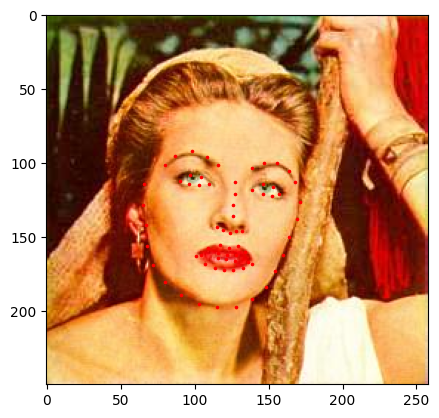

In [264]:
plt.figure()
show_landmarks(io.imread(os.path.join('./faces/', img_name)),
               landmarks)
plt.show()

In [265]:
landmarks[:, 0]

array([ 66.,  65.,  67.,  68.,  72.,  80.,  91., 103., 115., 128., 139.,
       148., 154., 160., 164., 169., 171.,  80.,  87.,  98., 108., 116.,
       139., 147., 156., 164., 168., 127., 127., 126., 126., 115., 119.,
       124., 128., 132.,  90.,  97., 104., 110., 103.,  96., 139., 146.,
       153., 157., 152., 146., 101., 109., 117., 123., 129., 134., 139.,
       133., 126., 120., 114., 107., 104., 116., 122., 128., 136., 127.,
       121., 116.])

In [266]:
landmarks[:, 1]

array([114., 128., 142., 156., 169., 180., 189., 195., 197., 197., 192.,
       184., 173., 162., 150., 138., 126., 101.,  95.,  92.,  96., 101.,
       103., 100., 100., 105., 113., 113., 121., 128., 136., 143., 145.,
       147., 146., 146., 112., 108., 109., 114., 115., 114., 118., 114.,
       116., 121., 122., 121., 163., 157., 155., 157., 156., 160., 168.,
       171., 172., 172., 171., 168., 162., 161., 162., 162., 167., 166.,
       165., 164.])

In [267]:
landmarks[0]

array([ 66., 114.])

### Dataset类介绍

#### 原理介绍

torch.utils.data.Dataset是一个PyTorch用来表示数据集的抽象类。

我们用这个类来处理自己的数据集的时候必须继承Dataset,然后重写下面的函数：

```__len__```: 使得len(dataset)返回数据集的大小；

```__getitem__```：使得支持dataset[i]能够返回第i个数据样本这样的下标操作。

#### 创建脸部图像数据集

- 在类的```__init__```函数中完成csv文件的读取工作；
- 在类的```__getitem__```函数中完成图片的读取工作。这样是为了减小内存开销，只要在需要用到的时候才将图片读入。
- 除此，数据集还会接收一个可以选择的参数transform，用来对图像做一些改变，具体的会在下面进行介绍。
- 最终返回的样本数据是一个字典形式的，如下所示：{‘image':image,'landmarks':landmarks}

那么现在我们就可以写出类的定义

In [268]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        csv_path = os.path.join(root_dir, csv_file)
        self.landmarks_frame = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

#### 实例化类

接下来我们对上面定义好的类做实例化，然后在数据样本上进行迭代。我们会打印前4个样本图像及其对应的坐标点。

0 (324, 215, 3) (68, 2)


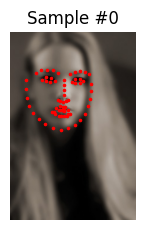

1 (500, 333, 3) (68, 2)


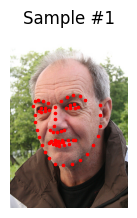

2 (250, 258, 3) (68, 2)


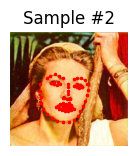

3 (434, 290, 3) (68, 2)


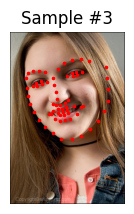

In [269]:
face_dataset = FaceLandmarksDataset(csv_file='face_landmarks.csv',
                                    root_dir='./faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(sample['image'], sample['landmarks'])

    if i == 3:
        plt.show()
        break

### Transforms

从上面显示的图片我们可以看到每张图片的大小都不一样，但往往我们在处理神经网络的输入图像的时候都希望它们有一个相对固定的大小。

因此，我们需要一些对图像进行预处理的工作。

#### 实现常用变换功能

我们试着写一下这三个常用的变换功能：

- Rescale：重新调整图像大小；
- RandomCrop：随机从图像中截取一部分；
- ToTensor：将numpy类型表示的图像转换成torch表示的图像。
我们用类而不是函数来实现以上这三个功能，主要是考虑到如果用函数的话，每次都需要传入参数，但是用类就可以省掉很多麻烦。我们只需要实现每个类的```__call__```函数和```__init__```函数。

下面是对这三个功能的实现

In [270]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

In [271]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [272]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

#### 组合以上变换功能

假设我们现在需要将图像的较短边调整到256，然后从中随机截取224的正方形图像。我们就可以调用```torchvision.transforms.Compose```将以上的```Rescale```和```RandomCrop```两个变换组合起来。

以下的代码段展示了分开进行变换以及用```Compose```组合进行变换的结果图

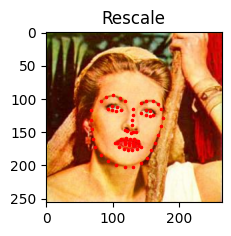

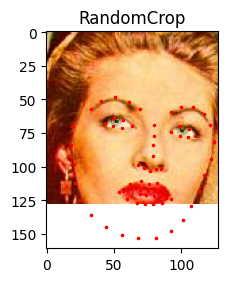

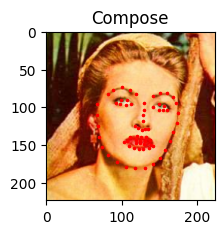

In [273]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[2]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

#### 合并dataset与transform、遍历数据集

简单回顾一下：

- 第３小节我们介绍了dataset类;
- 第４小节我们我们介绍了怎么样实现各个转换函数，然后将其组合起来。

如果你还记得的话，我们在之前定义dataset的时候是有一个transform参数的，但我们在第４节中是先取了样本数据，然后再进行变换操作，并没有将其作为参数传到dataset中。

所以我们现在要做的工作就是将所有的内容集成到一起。每次抽取一个样本，都会有以下步骤：

- 从文件中读取图片；
- 将转换应用于读入的图片；
- 由于做了随机选取的操作，所以起到了数据增强的效果。

其实我们只要把Transform的部分作为形参传入dataset就可以了，其他的都不变。

然后用for循环来依次获得数据集样本。

In [274]:
transformed_dataset = FaceLandmarksDataset(csv_file='face_landmarks.csv',
                                           root_dir='./faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


### DataLoader类介绍

以上我们已经实现了dataset与transform的合并，也实现了用for循环来获取每一个样本数据，好像事情就已经结束了。

但等等，真的结束了吗？我们好像还落了什么事情，是的没错：

- 按照batch_size获得批量数据；
- 打乱数据顺序；
- 用多线程multiprocessing来加载数据；

torch.utils.data.DataLoader这个类为我们解决了以上所有的问题

只要按照要求设置DataLoader的参数即可:

- 第一个参数传入transformed_dataset，即已经用了transform的Dataset实例。
- 第二个参数传入batch_size，表示每个batch包含多少个数据。
- 第三个参数传入shuffle，布尔型变量，表示是否打乱。
- 第四个参数传入num_workers表示使用几个线程来加载数据。

如下所示即实现了DataLoader函数的使用，及批样本数据的展示。

In [275]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

In [276]:
# Pytorch在win10中有bug，暂不支持多线程，num_worker只能为0，否则会报：Broken pip的错误
dataloader = DataLoader(transformed_dataset, 
                        batch_size=4,
                        shuffle=True, 
                        num_workers=0)

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


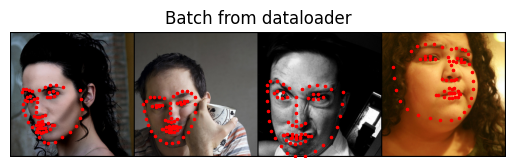

1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


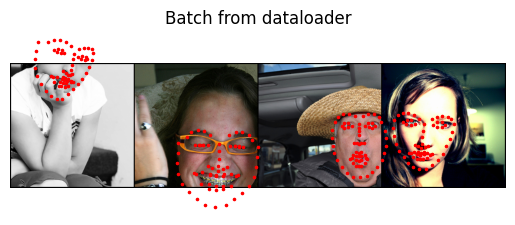

2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


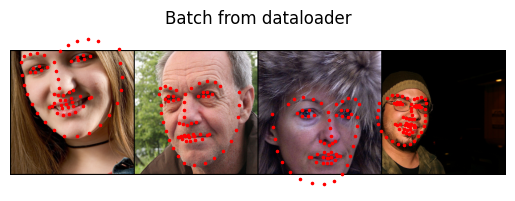

3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


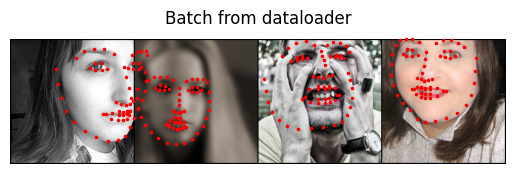

In [277]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, 
          sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    plt.figure()
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    if i_batch == 3:
        break

这样呢其实就完成了对数据集完整的处理了。

### torchvision

torchvision包提供了一些常用的数据集和转换函数。使用torchvision甚至不需要自己写处理函数。

在torchvision中最通用的数据集是ImageFolder，它假设数据结构为如下：

```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```

这里的root指代根目录，ants bees指的是不同的类标签，后面的是具体的图片名称。

当然它还提供了对PIL.Image的常用操作，包括RandomHorizontalFlip Scale等等。

以下为用torchvision实现的超简化版本的数据处理方法：

[flowers下载地址](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)

下载之后，将压缩文件解压到该jupyter notebook平级目录下的./flower_data/ 文件夹中，保留压缩文件夹的test, train, valid目录结构

In [288]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomResizedCrop(500),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
root_folder = r'./flower_data/train/'
flowers_dataset = datasets.ImageFolder(root=root_folder,
                                       transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(flowers_dataset,
                                             batch_size=4, 
                                             shuffle=True,
                                             num_workers=0)
print(flowers_dataset.class_to_idx)

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

In [289]:
for dl in dataset_loader:
    print(dl[0].size())
    print(dl[0])
    break

torch.Size([4, 3, 500, 500])
tensor([[[[-0.3369, -0.7137, -1.3130,  ...,  0.2967, -0.1999, -0.5082],
          [ 0.5707,  0.2453, -0.3198,  ..., -0.6623, -0.8335, -0.9363],
          [ 1.8208,  1.5468,  1.0844,  ..., -1.9295, -1.6898, -1.5357],
          ...,
          [-1.1760, -1.2103, -1.2617,  ..., -1.1760, -1.0390, -0.9534],
          [-1.2959, -1.3130, -1.3473,  ..., -1.1760, -1.0562, -0.9705],
          [-1.3987, -1.3987, -1.4158,  ..., -1.1760, -1.0562, -0.9877]],

         [[-0.2325, -0.6176, -1.2479,  ...,  0.4678, -0.0574, -0.3901],
          [ 0.6604,  0.3102, -0.2500,  ..., -0.4776, -0.6702, -0.7927],
          [ 1.8859,  1.6057,  1.1506,  ..., -1.7381, -1.4930, -1.3704],
          ...,
          [-0.2675, -0.3200, -0.4426,  ..., -0.6527, -0.5476, -0.4951],
          [-0.4776, -0.5126, -0.6001,  ..., -0.6352, -0.5301, -0.4776],
          [-0.6176, -0.6527, -0.7052,  ..., -0.6352, -0.5301, -0.4776]],

         [[ 0.0779, -0.3230, -0.9678,  ...,  0.8971,  0.3742,  0.0431],
 

In [290]:
# Helper function to show a batch
def show_flowers_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, tags_batch = \
            sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([4, 3, 500, 500]) tensor([76, 70, 89, 75])


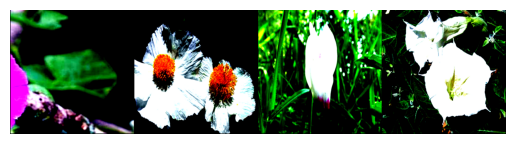

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([4, 3, 500, 500]) tensor([71, 98, 73, 91])


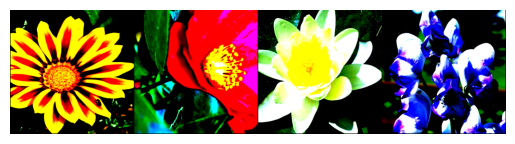

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([4, 3, 500, 500]) tensor([101,  39,  11,  20])


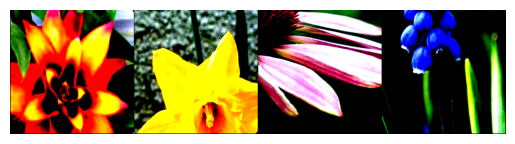

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([4, 3, 500, 500]) tensor([16, 49, 75, 47])


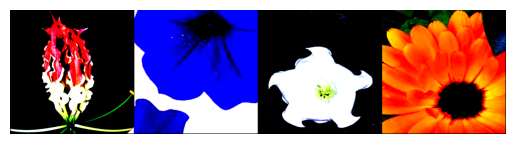

In [291]:
for i_batch, sample_batched in enumerate(dataset_loader):
    print(i_batch, 
          sample_batched[0].size(),
          sample_batched[1])

    # observe 4th batch and stop.
    plt.figure()
    show_flowers_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    if i_batch == 3:
        break

### nn.NLLLoss与nn.CrossEntropyLoss损失函数的使用

#### nn.NLLLoss

全名是负对数似然损失函数（Negative Log Likelihood），在PyTorch的文档中有如下说明

- Obtaining log-probabilities in a neural network is easily achieved by adding a LogSoftmax layer in the last layer of your network. You may use CrossEntropyLoss instead, if you prefer not to add an extra layer.
(翻译如下：在神经网络中获得对数概率可以通过在网络的最后一层添加一个LogSoftmax层来轻松实现。如果你不喜欢增加额外的一层，你可以使用CrossEntropyLoss来代替。)

简单来说，如果最后一层做了log softmax处理，那就直接使用nn.NLLLoss

#### nn.CrossEntropyLoss

CrossEntropy顾名思义就是交叉熵，概念来自香农的信息论，用于度量两个概率分布间的差异性信息，可以认为是在给定的真实分布下，使用非真实分布的策略消除系统的不确定性所需要付出的努力的大小。交叉熵越小，证明计算出的非真实分布越接近真实分布。

官方说明：<b> This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.</b>

代码演示

In [292]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [293]:
 #预测值
inputs_variable = torch.FloatTensor( [
[10, 0, 3,-1, 1],
[-1,-2, 0,-3,-4],
[-1, 1, 4, 8, 2]
])


#真实值
targets_variable = torch.LongTensor([1,2,3])

print(inputs_variable)
print(targets_variable)

tensor([[10.,  0.,  3., -1.,  1.],
        [-1., -2.,  0., -3., -4.],
        [-1.,  1.,  4.,  8.,  2.]])
tensor([1, 2, 3])


In [294]:
#分步计算log softmax
# 计算预测值的log softmax，这里有先计算softmax再取log和直接调用log_softmax函数两种方式，结果相同
softmax_result = F.softmax(inputs_variable, dim=1)
logsoftmax_result = np.log(softmax_result.data)
print('logsoftmax_result is {0}'.format(logsoftmax_result))
#logsoftmax_result:
#-0.0011 -10.0011  -7.0011 -11.0011  -9.0011
#-1.4519  -2.4519  -0.4519  -3.4519  -4.4519
#-9.0216  -7.0216  -4.0216  -0.0216  -6.0216
#[torch.FloatTensor of size 3x5]

#直接调用log_softmax
log_softmax_result = F.log_softmax(inputs_variable, dim=1)
print('log_softmax_result is {0}'.format(log_softmax_result))
#log_softmax_result:
#-0.0011 -10.0011  -7.0011 -11.0011  -9.0011
#-1.4519  -2.4519  -0.4519  -3.4519  -4.4519
#-9.0216  -7.0216  -4.0216  -0.0216  -6.0216
#[torch.FloatTensor of size 3x5]

logsoftmax_result is tensor([[-1.0967e-03, -1.0001e+01, -7.0011e+00, -1.1001e+01, -9.0011e+00],
        [-1.4519e+00, -2.4519e+00, -4.5191e-01, -3.4519e+00, -4.4519e+00],
        [-9.0216e+00, -7.0216e+00, -4.0216e+00, -2.1595e-02, -6.0216e+00]])
log_softmax_result is tensor([[-1.0967e-03, -1.0001e+01, -7.0011e+00, -1.1001e+01, -9.0011e+00],
        [-1.4519e+00, -2.4519e+00, -4.5191e-01, -3.4519e+00, -4.4519e+00],
        [-9.0216e+00, -7.0216e+00, -4.0216e+00, -2.1595e-02, -6.0216e+00]])


In [295]:
# 将求出的log softmax结果直接做为nn.NLLLoss的输入，得到损失计算结果
loss = nn.NLLLoss()
output = loss(log_softmax_result, targets_variable)
print(output)
# 3.4915
# [torch.FloatTensor of size 1]

tensor(3.4915)


In [296]:
# 计算每个样本的交叉熵再求平均，得到的结果和直接调用nn.CrossEntropyLoss函数相同
loss = nn.CrossEntropyLoss()
output = loss(inputs_variable, targets_variable)
print(output)
# 3.4915
# [torch.FloatTensor of size 1]

tensor(3.4915)
